In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import cv2
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from numpy import loadtxt
from tensorflow import keras
from sklearn import preprocessing
from  matplotlib import pyplot as plt
from sklearn.utils import class_weight
from sklearn.model_selection import KFold
from sklearn.preprocessing import normalize
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, model_from_json, Model
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import ResNet50, InceptionV3, EfficientNetB1, EfficientNetB1,EfficientNetB2, VGG19, EfficientNetB5, ConvNeXtXLarge,ConvNeXtLarge
from tensorflow.keras.layers import Input, Conv2D,Concatenate, LeakyReLU, Reshape, BatchNormalization, Flatten, Dense, Dropout, AveragePooling2D, MaxPool2D, GlobalAveragePooling2D, Input,  MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model

tf.get_logger().setLevel('ERROR')

2024-03-15 06:55:09.981754: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-15 06:55:09.981813: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-15 06:55:09.983252: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
base_dir = '/kaggle/input/indecskth-idol2/INDECS'

In [4]:
base_cloudy = "/kaggle/input/indecskth-idol2/INDECS/Cloudy"
base_sunny = "/kaggle/input/indecskth-idol2/INDECS/Sunny"
base_night = "/kaggle/input/indecskth-idol2/INDECS/Night"

In [5]:
Yolo_Cloudy = loadtxt('/kaggle/input/yolov8/YoloV8_Cloudy.csv', delimiter=',')
Yolo_Sunny = loadtxt('/kaggle/input/yolov8/YoloV8_Sunny.csv', delimiter=',')
Yolo_Night = loadtxt('/kaggle/input/yolov8/YoloV8_Night.csv', delimiter=',')

In [6]:
def preprocess_image(image_path, normalize=False):
    # Ler a imagem
    img = cv2.imread(image_path)
    # Converter de BGR (padrão do OpenCV) para RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Redimensionar a imagem para o tamanho esperado pelo modelo (224x224 neste caso)
    img = cv2.resize(img, (224, 224))
    if normalize:
        # Normalizar a imagem para ter valores entre 0 e 1
        img = img / 255.0
    # Expandir as dimensões da imagem para adicionar o batch size, que é esperado pelos modelos do Keras
    img = np.expand_dims(img, axis=0)
    
    return img

In [7]:
# Função para determinar o rótulo da imagem
def get_image_label(filename, labels):
    for i, label in enumerate(labels):
        if label in filename:
            return i
    return len(labels)

In [8]:
def load_data(directory, labels):
    images = []
    image_paths = []
    image_labels = []

    for filename in sorted(os.listdir(directory)):  # Sort the filenames
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_paths.append(os.path.join(directory, filename))
            label = get_image_label(filename, labels)
            image_labels.append(label)

    for image_path in image_paths:
        image = preprocess_image(image_path)
        images.append(image)

    images = np.vstack(images)
    test_labels = np.array(image_labels)

    # one hot encode target values
    image_labels = to_categorical(image_labels, num_classes=5)
    print(image_labels.shape)
    # print(labels[5])

    # convert from integers to floats
    images = images.astype('float32')
    print(images.shape)

    return images, image_labels, test_labels

In [9]:
scaler = StandardScaler()
Yolo_Night_norm = scaler.fit_transform(Yolo_Night)
Yolo_Sunny_norm = scaler.transform(Yolo_Sunny)
Yolo_Cloudy_norm = scaler.transform(Yolo_Cloudy)

In [10]:
labels_1 = ['rPR', 'rEO', 'rKT', 'rCR', 'rBO']
labels_2 = ['rPA', 'rEO', 'rKT', 'rCR', 'rBO']

X_train, y_train, test_labels_train = load_data(base_night,labels_1)

X_test_cloudy, y_test_cloudy, test_labels_cloudy  = load_data(base_cloudy,labels_1)
X_test_sunny, y_test_sunny, test_labels_sunny = load_data(base_sunny,labels_1)

(1092, 5)
(1092, 224, 224, 3)
(1080, 5)
(1080, 224, 224, 3)
(1080, 5)
(1080, 224, 224, 3)


In [11]:
# Normaliza apenas os dados para o autoencoder
X_train_autoencoder = X_train / 255.0
X_cloudy_auto = X_test_cloudy / 255.0
X_sunny_auto = X_test_sunny / 255.0

In [12]:
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization, Flatten, Dense, Reshape, Conv2DTranspose, Activation
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

def build_autoencoder(input_shape):
    input_img = Input(shape=input_shape)
    # Encoder
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(input_img)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    # Bottleneck
    encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    # Decoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    encoder = Model(input_img, encoded)
    autoencoder.compile(optimizer=Adam(learning_rate=1e-4), loss='mean_squared_error')

    return autoencoder, encoder

In [13]:
# autoencoder, encoder = build_autoencoder(input_shape=(224, 224, 3))

In [14]:
# Treinar o autoencoder
# autoencoder.fit(X_train_autoencoder, X_train_autoencoder, batch_size=16, epochs=100, validation_split=0.2)

In [15]:
# encoder.save('encoder_model.keras')

encoder = load_model('encoder_model.keras')

In [16]:
X_train_encoder = encoder.predict(X_train_autoencoder)
X_cloudy_encoder = encoder.predict(X_cloudy_auto)
X_sunny_encoder = encoder.predict(X_sunny_auto)

X_train_encoder_flattened = X_train_encoder.reshape(X_train_encoder.shape[0], -1)
X_cloudy_encoder_flattened = X_cloudy_encoder.reshape(X_cloudy_encoder.shape[0], -1)
X_sunny_encoder_flattened = X_sunny_encoder.reshape(X_sunny_encoder.shape[0], -1)

2024-03-15 06:55:48.354029: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng15{k5=1,k6=0,k7=1,k10=1} for conv (f32[32,256,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,224,224]{3,2,1,0}, f32[256,3,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-03-15 06:55:50.311442: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50176: 4.10647, expected 3.52349
2024-03-15 06:55:50.311510: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50183: 4.25255, expected 3.66957
2024-03-15 06:55:50.311528: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50184: 4.31772, expected 3.73474
2024-03-15 06:55:50.311546: E external/local_xla/xla/service/gpu/buffer_compar

 7/35 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

I0000 00:00:1710485761.284824   13118 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

2024-03-15 06:56:02.707807: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50176: 3.20884, expected 2.4969
2024-03-15 06:56:02.707867: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50177: 4.79493, expected 4.083
2024-03-15 06:56:02.707877: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50178: 5.01304, expected 4.3011
2024-03-15 06:56:02.707884: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50179: 4.75212, expected 4.04019
2024-03-15 06:56:02.707892: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50180: 4.66987, expected 3.95794
2024-03-15 06:56:02.707900: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50181: 4.88946, expected 4.17753
2024-03-15 06:56:02.707907: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50182: 3.96805, expected 3.25611
2024-03-15 06:56:02.707915: E e

35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 113ms/step
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

2024-03-15 06:56:10.154538: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng15{k5=1,k6=0,k7=1,k10=1} for conv (f32[24,256,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[24,3,224,224]{3,2,1,0}, f32[256,3,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-03-15 06:56:11.322029: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.83845, expected 2.32556
2024-03-15 06:56:11.322105: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 4.01038, expected 3.49748
2024-03-15 06:56:11.322124: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 3.09223, expected 2.57934
2024-03-15 06:56:11.322139: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137

34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 357ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


In [17]:
encoded_input = Input(shape=(X_train_encoder_flattened.shape[1],), name='encoded_input') 

def build_classifier(input_shape):
    base_model = tf.keras.applications.ConvNeXtXLarge(include_top=False, input_shape=input_shape, weights='imagenet')
    base_model.trainable = False

    x = base_model.output
    x = Dense(512, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    
    model = Model(inputs=base_model.input, outputs=x)
    
    return model

# Define input shapes
input_shape_classifier = (224, 224, 3)
input_shape_detector = (Yolo_Cloudy.shape[1],)

# Define input layers for classifier and detector
classifier_input = Input(shape=input_shape_classifier, name='classifier_input')
detector_input = Input(shape=input_shape_detector, name='detector_input')

# Define your classifier model
classifier_model = build_classifier(input_shape_classifier)
classifier_output = classifier_model(classifier_input)

# Define fully connected hidden layers for the detector input
classifier_flattened = Flatten()(classifier_output)
x_detector = Dense(128, activation='relu')(detector_input)
x_detector = Dense(64, activation='relu')(x_detector)

# Concatenate the classifier output and detector hidden layers
combined_features = Concatenate()([classifier_flattened, x_detector])

# Output layer for classification
output_layer = Dense(5, activation='softmax')(combined_features)

# Define the fused model with both inputs and output
fused_model = Model(inputs=[classifier_input, encoded_input, detector_input], outputs=output_layer)
opt = Adam(learning_rate=0.0001)
fused_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
# def build_fused_model(input_shape_classifier, input_shape_detector, input_shape_encoded):
#     # Base Model
#     base_model = tf.keras.applications.ConvNeXtXLarge(include_top=False, input_shape=input_shape_classifier, weights='imagenet')
#     base_model.trainable = False

#     # Classifier Output
#     x = GlobalAveragePooling2D()(base_model.output) # Usar GlobalAveragePooling2D para reduzir dimensões
#     x = Dense(512, activation='relu')(x)
#     x = Dense(256, activation='relu')(x)

#     # Detector Input
#     detector_input = Input(shape=input_shape_detector, name='detector_input')
#     x_detector = Dense(128, activation='relu')(detector_input)
#     x_detector = Dense(64, activation='relu')(x_detector)

#     # Encoded Input (adicionado ao modelo para lidar com as características codificadas)
#     encoded_input = Input(shape=input_shape_encoded, name='encoded_input')

#     # Combining Classifier, Detector, and Encoded inputs
#     combined_features = Concatenate()([x, x_detector, Flatten()(encoded_input)])

#     # Output Layer
#     output_layer = Dense(5, activation='softmax')(combined_features)

#     # Fused Model
#     fused_model = Model(inputs=[base_model.input, encoded_input, detector_input], outputs=output_layer)

#     # Compilation
#     opt = Adam(learning_rate=0.0001)
#     fused_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

#     return fused_model

# # Exemplo de Uso
# input_shape_classifier = (224, 224, 3)
# input_shape_detector = (Yolo_Cloudy.shape[1],)  # Ajuste isso de acordo com a sua variável Yolo_Cloudy
# input_shape_encoded = (X_train_encoder_flattened.shape[1],)  # Exemplo de formato, ajuste conforme necessário

# fused_model = build_fused_model(input_shape_classifier, input_shape_detector, input_shape_encoded)
# # # fused_model.summary()

In [19]:
# Early stopping para evitar overfitting
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

In [20]:
# Define a callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    filepath='/kaggle/working/melhor_modelo_night.keras',  # O caminho onde o modelo será salvo
    save_best_only=True,  # Salva apenas o melhor modelo
    monitor='val_accuracy',  # Métrica para determinar o "melhor"
    mode='max',
    verbose=1
)

In [21]:
# # Classes
# classes = np.unique(np.argmax(y_train, axis=1))
# class_weights = compute_class_weight('balanced', classes=classes, y=np.argmax(y_train, axis=1))
# class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
# print("Pesos das classes:", class_weights_dict)

Pesos das classes: {0: 1.011111111111111, 1: 1.3, 2: 1.011111111111111, 3: 0.56875, 4: 2.022222222222222}


In [22]:
# class_weights_dict = {0: 6.0, 1: 1.4, 2: 1.0, 3: 0.56875, 4: 2.2}
class_weights_dict = {0: 2.6, 1: 1.3, 2: 1.011111111111111, 3: 0.56875, 4: 2.2}

history = fused_model.fit(
    [X_train, X_train_encoder_flattened, Yolo_Night_norm], y_train,
    batch_size=16, epochs=15, verbose=1,
    validation_data=([X_test_cloudy, X_cloudy_encoder_flattened, Yolo_Cloudy], y_test_cloudy),
    class_weight=class_weights_dict,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/15


W0000 00:00:1710485823.395776   13117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710485823.396187   13117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710485823.396676   13117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710485823.397060   13117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710485823.397451   13117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710485823.397851   13117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710485823.398225   13117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710485823.398614   13117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.3843 - loss: 1.8249

W0000 00:00:1710485852.160836   13118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710485862.490683   13119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710485862.491150   13119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710485862.491621   13119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710485862.491987   13119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710485862.492329   13119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710485862.492687   13119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710485862.493032   13119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.73241, saving model to /kaggle/working/melhor_modelo_night.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.3863 - loss: 1.8188 - val_accuracy: 0.7324 - val_loss: 0.7652
Epoch 2/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.8944 - loss: 0.3857
Epoch 2: val_accuracy improved from 0.73241 to 0.78426, saving model to /kaggle/working/melhor_modelo_night.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 53s 768ms/step - accuracy: 0.8944 - loss: 0.3855 - val_accuracy: 0.7843 - val_loss: 0.6084
Epoch 3/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.9772 - loss: 0.1623
Epoch 3: val_accuracy improved from 0.78426 to 0.81296, saving model to /kaggle/working/melhor_modelo_night.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 53s 779ms/step - accuracy: 0.9770 - loss: 0.1622 - val_accuracy: 0.8130 - val_loss: 0.5145
Epoch 4/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.9949 - loss: 0.0834
Epoch 4: val_accuracy improved from 0.81296 to 0.8

In [23]:
# # Após o treinamento inicial, descongelar as últimas camadas e continuar o fine-tuning
# for layer in fused_model.layers:
#     if hasattr(layer, 'trainable'):
#         layer.trainable = True

# # Re-compilar o modelo com uma taxa de aprendizado muito baixa para o fine-tuning
# fused_model.compile(optimizer=Adam(learning_rate=0.000001), loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
# # Continuar o treinamento para o fine-tuning com taxa de aprendizado reduzida
# history_fitining = fused_model.fit(
#     [X_train, X_train_encoder_flattened, Yolo_Night_norm], y_train,
#     batch_size=16, epochs=10, verbose=1,
#     validation_data=([X_test_cloudy, X_cloudy_encoder_flattened, Yolo_Cloudy], y_test_cloudy),
#     class_weight=class_weights_dict,
#     callbacks=[early_stopping, model_checkpoint]
# )

In [25]:
# Evaluate the fused model on the combined test data
results_cloudy = fused_model.evaluate([X_test_cloudy,X_cloudy_encoder_flattened,Yolo_Cloudy_norm], y_test_cloudy)
print(results_cloudy)

W0000 00:00:1710486484.014354   13117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710486484.014738   13117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710486484.015395   13117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - accuracy: 0.8654 - loss: 0.4113

W0000 00:00:1710486511.024834   13117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710486511.025202   13117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710486511.025671   13117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710486511.026036   13117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710486511.026395   13117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710486511.026756   13117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710486511.027098   13117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710486511.027445   13117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


34/34 ━━━━━━━━━━━━━━━━━━━━ 36s 815ms/step - accuracy: 0.8669 - loss: 0.4069
[0.33524391055107117, 0.8916666507720947]


In [26]:
results_sunny = fused_model.evaluate([X_test_sunny,X_sunny_encoder_flattened,Yolo_Sunny_norm], y_test_sunny)
print(results_sunny)

34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 585ms/step - accuracy: 0.8338 - loss: 0.4291
[0.38285335898399353, 0.8629629611968994]


In [27]:
results_night = fused_model.evaluate([X_train, X_train_encoder_flattened, Yolo_Night_norm], y_train)

35/35 ━━━━━━━━━━━━━━━━━━━━ 24s 691ms/step - accuracy: 1.0000 - loss: 0.0112


W0000 00:00:1710486562.668220   13118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [28]:
pC = fused_model.predict([X_test_cloudy,X_cloudy_encoder_flattened,Yolo_Cloudy_norm])
predC = np.argmax(pC, axis = 1)
pS = fused_model.predict([X_test_sunny, X_sunny_encoder_flattened, Yolo_Sunny_norm])
predS = np.argmax(pS, axis = 1)

 1/34 ━━━━━━━━━━━━━━━━━━━━ 3:45 7s/step

W0000 00:00:1710486573.145331   13118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710486573.145767   13118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710486573.146313   13118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


34/34 ━━━━━━━━━━━━━━━━━━━━ 32s 757ms/step


W0000 00:00:1710486598.099353   13117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710486598.099725   13117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710486598.100096   13117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710486598.100361   13117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710486598.100640   13117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710486598.100928   13117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710486598.101378   13117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710486598.101766   13117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 573ms/step


In [29]:
print(classification_report(predC,test_labels_cloudy))

              precision    recall  f1-score   support

           0       0.77      0.98      0.86       171
           1       0.96      0.83      0.89       195
           2       0.96      0.95      0.95       220
           3       0.92      0.86      0.89       400
           4       0.77      0.88      0.82        94

    accuracy                           0.89      1080
   macro avg       0.88      0.90      0.88      1080
weighted avg       0.90      0.89      0.89      1080



In [30]:
print(classification_report(predS,test_labels_sunny))

              precision    recall  f1-score   support

           0       0.70      0.97      0.81       156
           1       0.95      0.73      0.82       204
           2       0.95      0.89      0.92       232
           3       0.92      0.87      0.89       407
           4       0.69      0.91      0.78        81

    accuracy                           0.86      1080
   macro avg       0.84      0.87      0.85      1080
weighted avg       0.88      0.86      0.87      1080



In [31]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    # Show all ticks and label them with the respective list entries
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

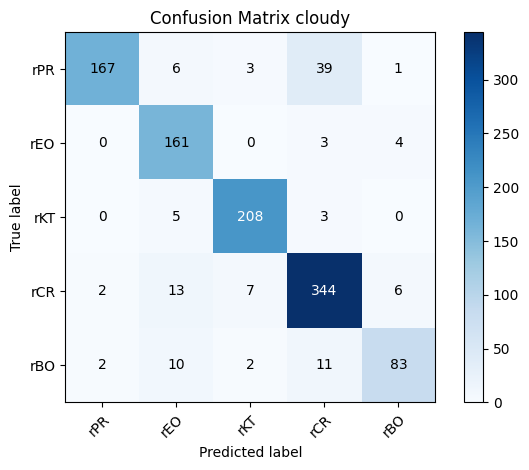

In [32]:
plot_confusion_matrix(test_labels_cloudy, predC, classes=labels_1, normalize=False, title='Confusion Matrix cloudy')
plt.show()

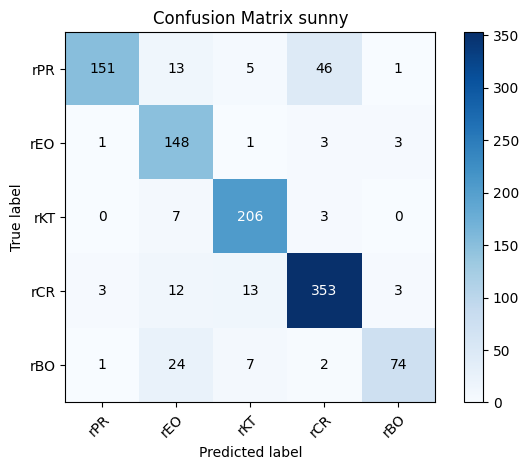

In [33]:
plot_confusion_matrix(test_labels_sunny, predS, classes=labels_1, normalize=False, title='Confusion Matrix sunny')
plt.show()

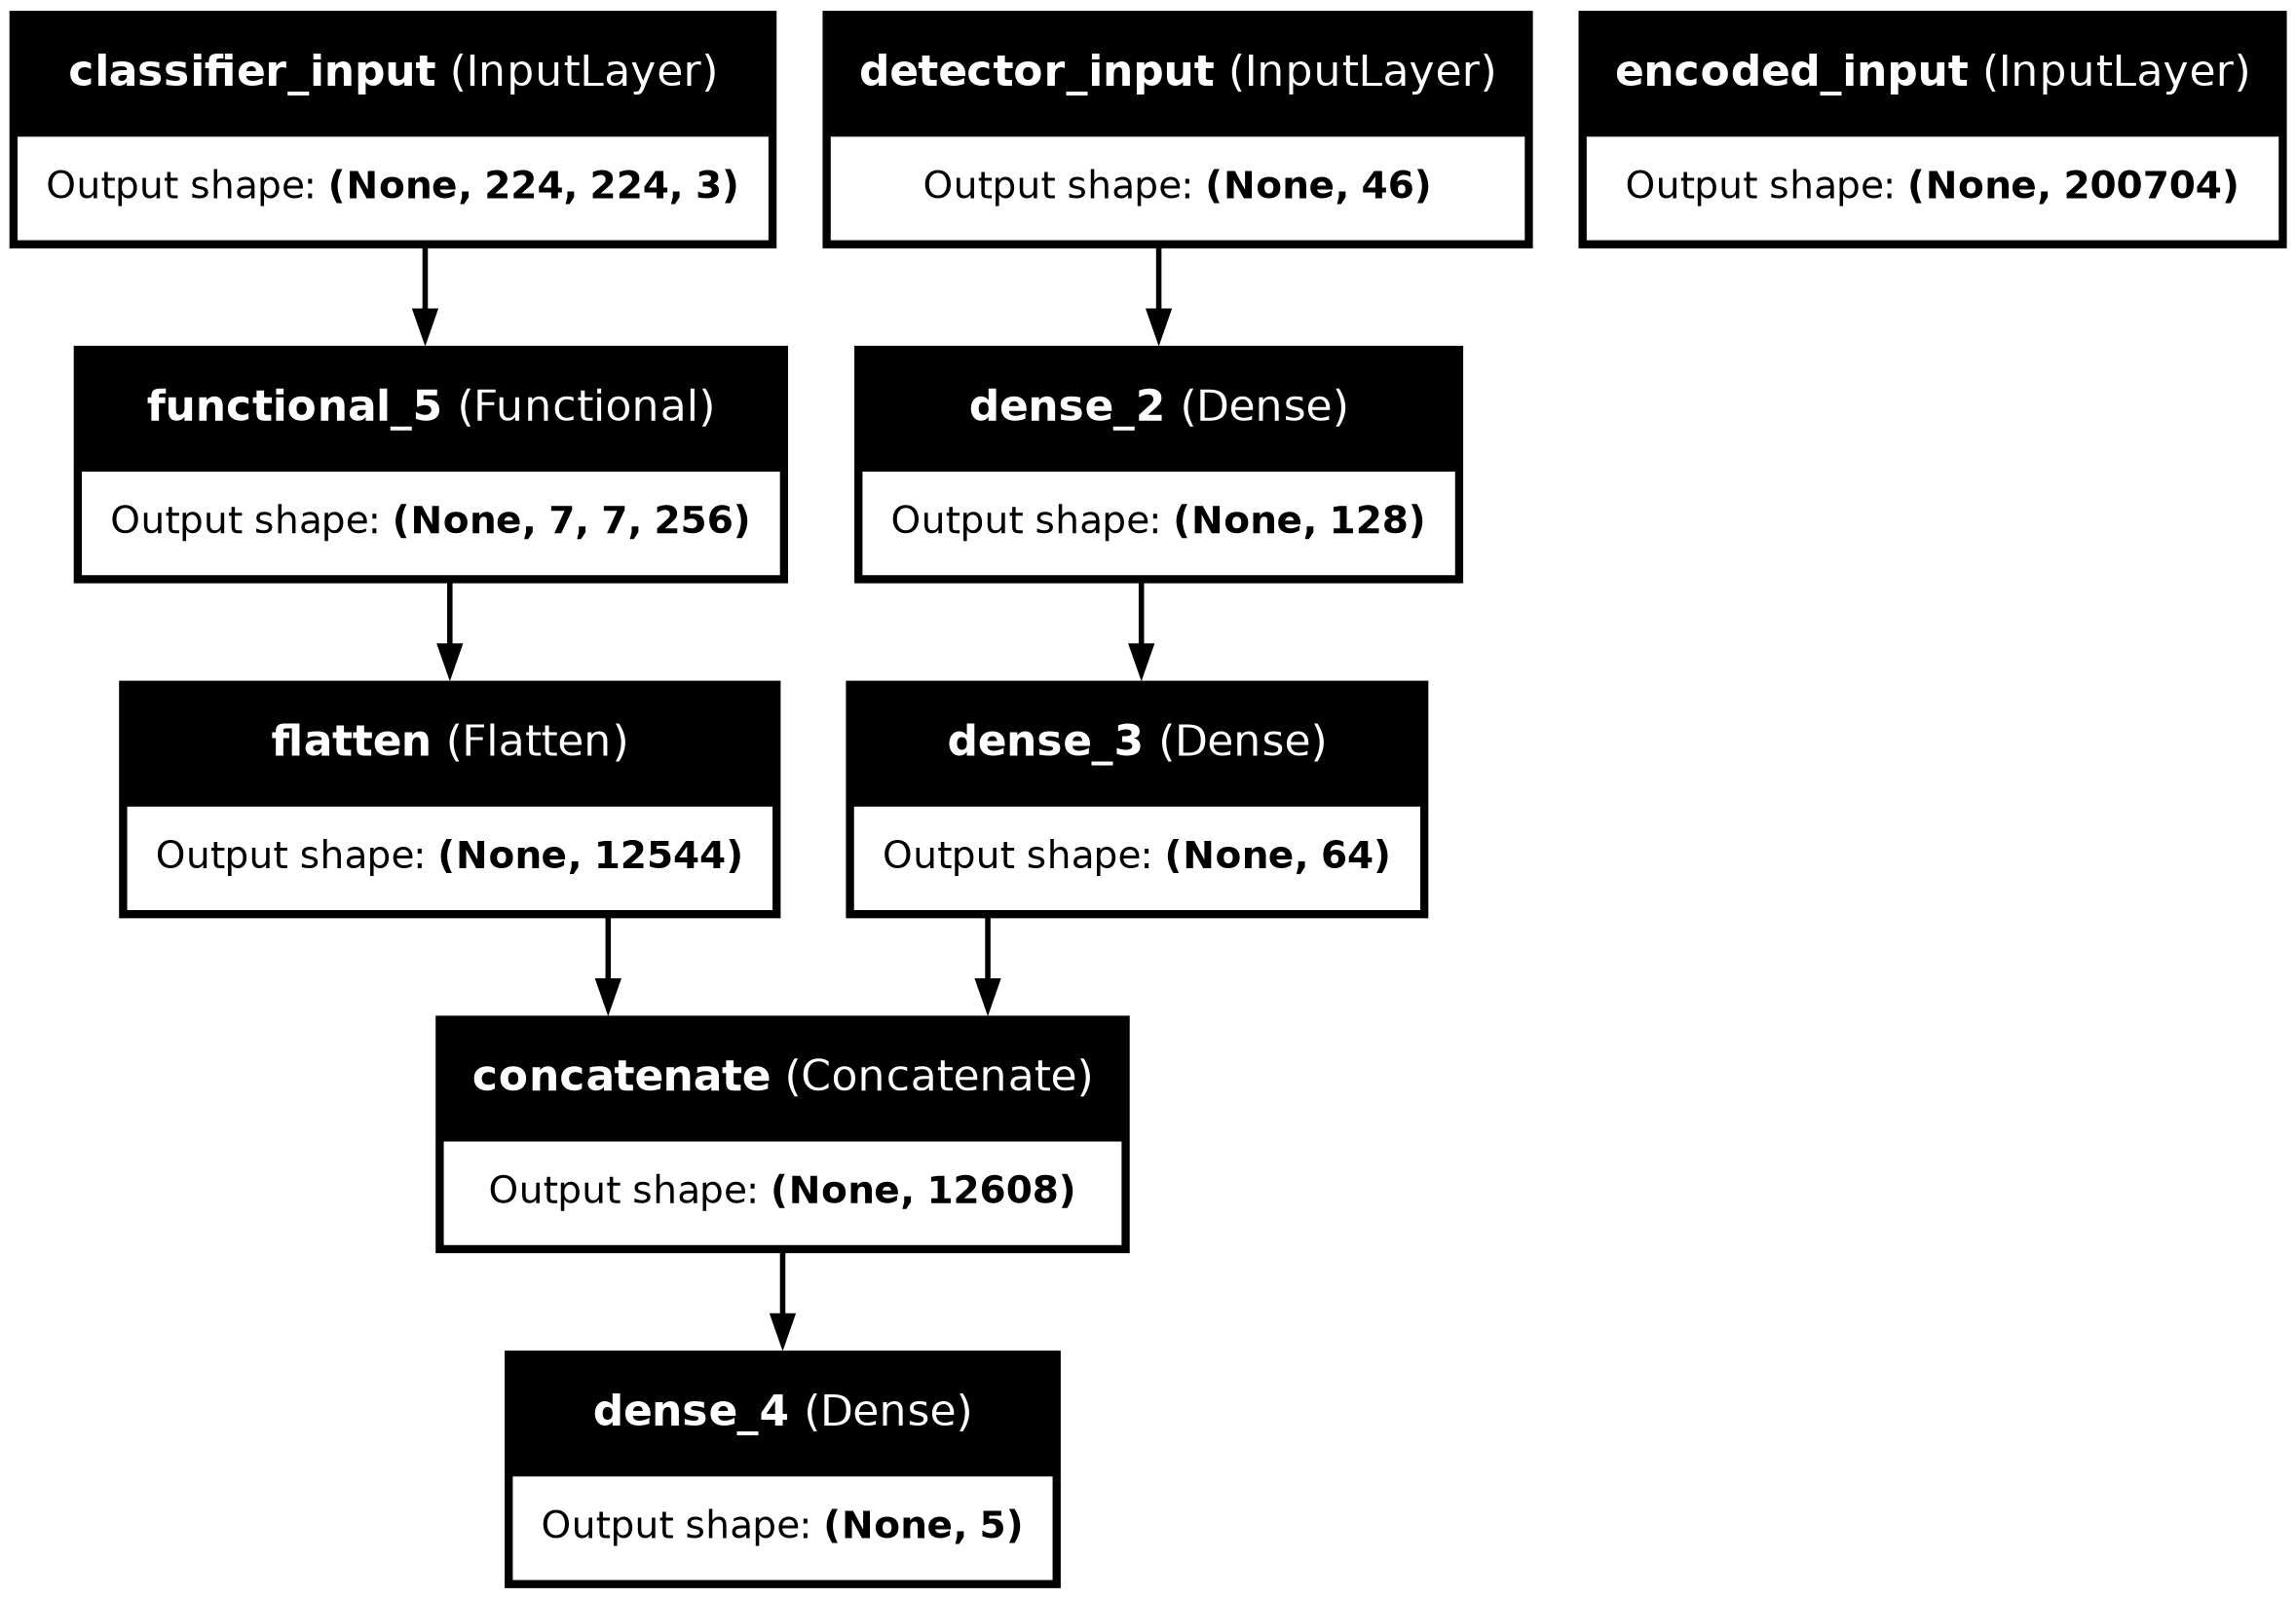

In [34]:
plot_model(fused_model, to_file='Model.png', show_shapes=True, show_layer_names=True)

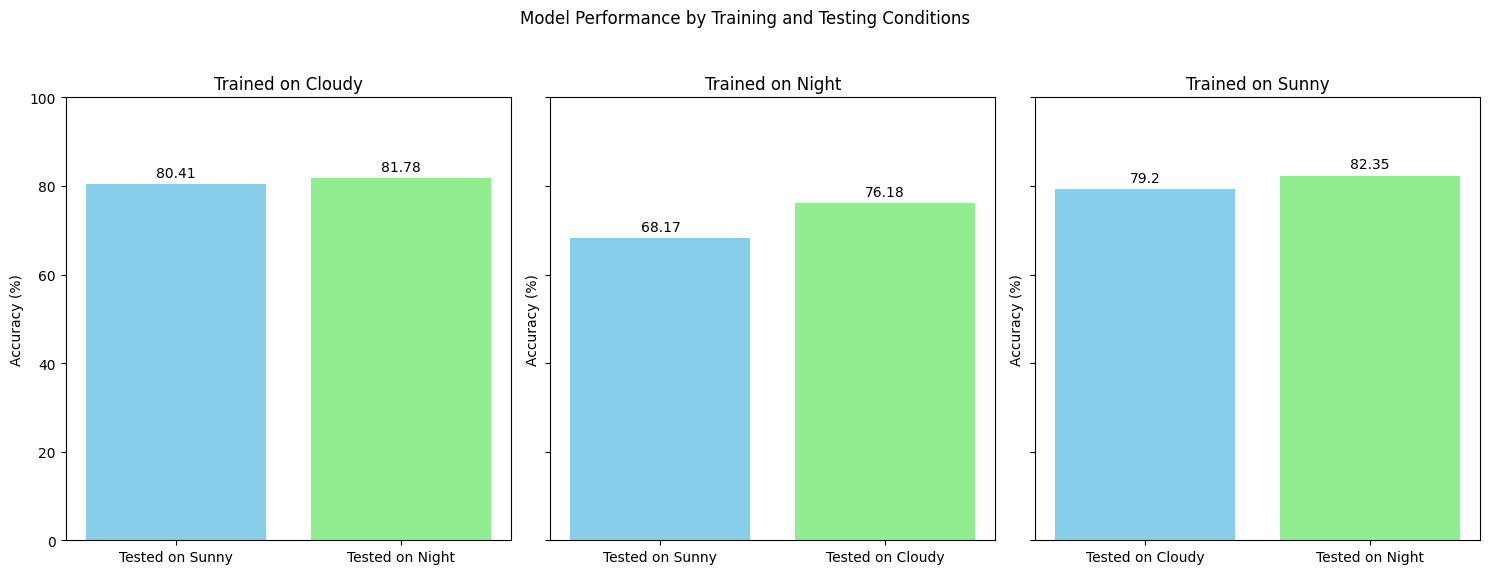

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Define the accuracy scores for each training condition
scores = {
    "Trained on Cloudy": {"Tested on Sunny": 80.41, "Tested on Night": 81.78},
    "Trained on Night": {"Tested on Sunny": 68.17, "Tested on Cloudy": 76.18},
    "Trained on Sunny": {"Tested on Cloudy": 79.20, "Tested on Night": 82.35}
}

# Set up the figure and axes for plotting
fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharey=True)
fig.suptitle('Model Performance by Training and Testing Conditions')

# Colors and labels for the plots
colors = ['skyblue', 'lightgreen', 'lightcoral']
labels = list(scores.keys())

# Loop through the scores to plot
for ax, (label, tests) in zip(axes, scores.items()):
    # Data for the bars
    test_labels = list(tests.keys())
    accuracies = list(tests.values())

    # Create the bar plot
    bars = ax.bar(test_labels, accuracies, color=colors[:len(tests)])

    # Add the data labels on top of the bars
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

    ax.set_title(label)
    ax.set_ylim(0, 100)
    ax.set_ylabel('Accuracy (%)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()